In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import matplotlib.pyplot as plt

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")     

In [ ]:
# !wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

# uncomment to get the data

In [19]:
df = pd.read_csv('airline_passengers.csv', index_col=0, parse_dates=True)

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [20]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [25]:
# frequency of the index is not set, so we set it 


df.index.freq = 'MS'

check the [link](https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases) for how to set the frequency of datetime index

In [26]:
# initialize an instance of the SES with the series, how you determine the first value is determined by the initialization_method

ses = SimpleExpSmoothing(df['Passengers'], initialization_method='legacy-heuristic')

In [27]:
alpha = 0.2

result = ses.fit(smoothing_level = alpha, optimized = False)

result.summary()

Dep. Variable:,Passengers,No. Observations:,144
Model:,SimpleExpSmoothing,SSE,327021.846
Optimized:,False,AIC,1116.828
Trend:,None,BIC,1122.767
Seasonal:,None,AICC,1117.115
Seasonal Periods:,None,Date:,"Thu, 04 Apr 2024"
Box-Cox:,False,Time:,16:08:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
initial_level,112.00000,l.0,False


In [28]:
# Assing the in sample predictions of the model to a new column for the df, also get the exponentially smoothed time series 

df['EWMA'] = df['Passengers'].ewm(alpha = alpha, adjust=False).mean()

df['SES'] = result.predict(start= df.index[0], end = df.index[-1])

df['SES']

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Name: SES, Length: 144, dtype: float64

In [29]:
# predict method for the in sample data returns the same result as result.fittedvalues

np.allclose(df['SES'], result.fittedvalues)

True

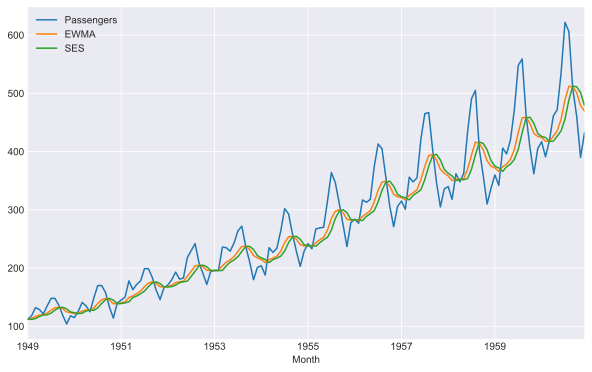

In [30]:
fig, axis = plt.subplots(figsize = (10,6))

df.plot(ax = axis)

axis.grid()

Result from SES model are different from EWMA smoothed TS where SES prediction for the in sample data goes one month ahead. This is expected as the SES model which we use for forecasting is defined slightly different than the EWMA! The forecasting time index is actually moved up by one step: 

$$ \textrm{Forecast equation:\quad} \hat{y}_{t+h|t} = l_t,\quad h = 1,2,3,\dots$$

$$  \textrm{Exponential Smoothing equation:\quad} l_t = \alpha y_t + (1-\alpha)l_{t-1} $$

EMWA is represented by the level $l$ but the prediction $\hat{y}$ assigns the level at the previous time step.

In [31]:
# split the dataset as train, test

N_test = 12
train, test = df[:-N_test], df[-N_test:]

In [33]:
# initialize ses with the traning set and fit without passing any arguments for smoothing level and optimized flag

ses = SimpleExpSmoothing(train['Passengers'], initialization_method='legacy-heuristic')

result = ses.fit()

result.summary()

Dep. Variable:,Passengers,No. Observations:,132
Model:,SimpleExpSmoothing,SSE,128977.367
Optimized:,True,AIC,912.766
Trend:,None,BIC,918.532
Seasonal:,None,AICC,913.081
Seasonal Periods:,None,Date:,"Thu, 04 Apr 2024"
Box-Cox:,False,Time:,16:27:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,112.00000,l.0,False


Notice that since we did not set a default alpha (as an argument) in the .fit() method, the model optimized its value and found $\alpha = 0.995$ instead.

In [35]:
# Boolean series to slice df rows 

train_idx = df.index <= train.index[-1] # if df index is smaller than the last index in the training set, it will will return true
test_idx = df.index > train.index[-1]

In [36]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [44]:
# insert the fitted values and forecasts to the df according to the train,test split 

df.loc[train_idx,'SESoptim'] = result.fittedvalues
df.loc[test_idx, 'SESoptim'] = result.forecast(N_test)


In [48]:
df.head()

,Passengers,EWMA,SES,SESoptim
Month,,,,
1949-01-01,112,112.0000,112.000,112.000000
1949-02-01,118,113.2000,112.000,112.000000
1949-03-01,132,116.9600,113.200,117.970000
1949-04-01,129,119.3680,116.960,131.929850
1949-05-01,121,119.6944,119.368,129.014649


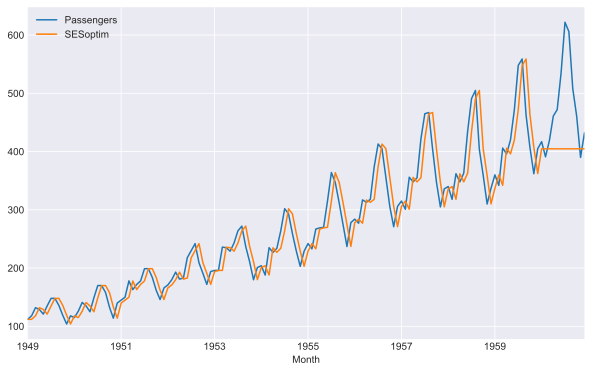

In [50]:
fig, axis = plt.subplots(figsize= (10,6))

df[['Passengers','SESoptim']].plot(ax = axis)

axis.grid()

Forecast is a horizontal line because the optimized $\alpha = 0.995$ is very close to one corresponding to an almost Naive forecast! Again the training predictions is one month ahead!  

In [51]:
result.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}